In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import traceback

Helper functions for handling the interpolation of the ground truth

In [2]:
class Trace(object):
    def __init__(self, params):
        self.times = []
        self.params = {}
        for p in params:
            self.params[p] = []
    def frame(self, t, **params):
        self.times.append(t)
        for p in self.params.keys():
            if p not in params:
                self.params[p].append(self.params[p][-1])
            else:
                self.params[p].append(params[p])

    def get(self, t, p):
        if t < self.times[0]:
            return None
        elif t > self.times[-1]:
            return None
        else:
            return np.interp([t], self.times, self.params[p])[0]


def load_trace(fn):
    if not os.path.isfile(fn):
        return None
    else:
        with open(fn) as f:
            code = f.read()
        locals = dict()
        globals = dict(Trace=Trace)
        try:
            exec(code, globals, locals)
        except:
            traceback.print_exc()
            return None
        for k, v in locals.items():
            if isinstance(v, Trace):
                return v
        else:
            return None


Load in a data file and turn it into a big list of images and ground truth data

In [3]:
def extract_targets(filename, dt, t_start=None, t_end=None):
    trace = load_trace(filename+'.label')
    if t_end is None:        
        t_end = trace.times[-1] if trace is not None and len(trace.times)>0 else -1
    if t_start is None:
        t_start = 0
        
    times = []
    targets = []
    now = t_start
    while now < t_end:
        xx = trace.get(now, 'x')
        yy = trace.get(now, 'y')
        rr = trace.get(now, 'r')
        valid = 1 if xx is not None else 0
        if xx is None:
            xx = -1
        if yy is None:
            yy = -1
        if rr is None:
            rr = -1

        now += dt

        targets.append([xx, yy, rr, valid])
        times.append(now)

    targets = np.array(targets).reshape(-1, 4)
    times = np.array(times)
    
    return times, targets
        
    

In [158]:
def extract_images(filename,        # filename to load data from 
                   dt,              # time between images to create (seconds)
                   decay_time=0.1,  # spike decay time (seconds)
                   t_start=None,    # time to start generating images (seconds)
                   t_end=None       # time to end generating images (seconds)
                  ):
    packet_size = 8

    with open(filename, 'rb') as f:
        data = f.read()
    data = np.fromstring(data, np.uint8)

    # find x and y values for events
    y = ((data[1::packet_size].astype('uint16')<<8) + data[::packet_size]) >> 2
    x = ((data[3::packet_size].astype('uint16')<<8) + data[2::packet_size]) >> 1
    # get the polarity (+1 for on events, -1 for off events)
    p = np.where((data[::packet_size] & 0x02) == 0x02, 1, -1)
    v = np.where((data[::packet_size] & 0x01) == 0x01, 1, -1)
    # find the time stamp for each event, in seconds from the start of the file
    t = data[7::packet_size].astype(np.uint32)
    t = (t << 8) + data[6::packet_size]
    t = (t << 8) + data[5::packet_size]
    t = (t << 8) + data[4::packet_size]
    #t = t - t[0]
    t = t.astype(float) / 1000000   # convert microseconds to seconds

    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = t[-1]

    image = np.zeros((180, 240), dtype=float)

    images = []
    targets = []
    times = []

    event_index = 0   # for keeping track of where we are in the file
    if t_start > 0:
        event_index = np.searchsorted(t, t_start)

    now = t_start

    event_dt = dt

    while now < t_end:
        if event_dt != 0:
            decay_scale = 1-np.abs(event_dt)/(np.abs(event_dt)+decay_time)
            image *= decay_scale

        if event_dt > 0:
            count = np.searchsorted(t[event_index:], now + event_dt)
            s = slice(event_index, event_index+count)

            dts = event_dt-(t[s]-now)
            image[y[s], x[s]] += p[s] * (1-dts / (dts+decay_time))
            event_index += count

        now += event_dt

        images.append(image.copy())
        times.append(now)

    images = np.array(images)
    times = np.array(times)
    
    return times, images



Let's look at the target data

c:\users\terry\py3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


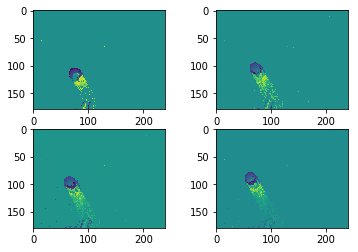

In [182]:
times, images = extract_images('dvs_data/retinaTest95.events', dt=0.01, decay_time=0.01, t_start=1.55, t_end=1.9)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])

In [177]:
import pytry
import os
import random
import nengo
import nengo_extras

class TrackingTrial(pytry.PlotTrial):
    def params(self):
        self.param('number of data sets to use', n_data=10)
        self.param('data directory', dataset_dir=r'dvs_data')
        self.param('keep invalid frames (ones with no ball)', keep_invalid=True)
        self.param('task (valid|location)', task='valid')
        self.param('dt', dt=0.01)
        self.param('decay time (input synapse)', decay_time=0.01)
        self.param('number of neurons', n_neurons=100)
        self.param('gabor size', gabor_size=11)
        self.param('solver regularization', reg=0.03)
        self.param('test set (odd|one)', test_set='last')
        self.param('enhance training set with flips', enhance_training=True)
        
    def evaluate(self, p, plt):
        files = []
        sets = []
        for f in os.listdir(p.dataset_dir):
            if f.endswith('events'):
                files.append(f)
                
        n_data = p.n_data if p.n_data != -1 else len(files)
        for f in random.sample(files, n_data):
            times, targets = extract_targets(os.path.join(p.dataset_dir, f),
                                     dt=p.dt,
                                     )
            sets.append([f, times, targets])
            
        if p.keep_invalid:
            for s in sets:
                times, images = extract_images(os.path.join(p.dataset_dir, s[0]),
                                     dt=p.dt, decay_time=p.decay_time,
                                     )
                extra_targets = np.tile([[-1, -1, -1, 0]], (len(times)-len(s[1]),1))
                s[2] = np.vstack([s[2], extra_targets])
                s.append(images)
        else:
            for s in sets:
                index = 0
                while s[2][index][3] == 0:
                    index += 1
                    
                times, images = extract_images(os.path.join(p.dataset_dir, s[0]),
                                     dt=p.dt, decay_time=p.decay_time,
                                     t_start=s[1][index]-2*p.dt, t_end=s[1][-1]-p.dt,
                                     )
                s[1] = s[1][index:]
                s[2] = s[2][index:]
                s.append(images)
                
                
        
        inputs = []
        targets = []
        if p.task == 'valid':
            for f, times, targ, images in sets:
                inputs.append(images)
                targets.append(targ[:,3:])
        elif p.task == 'location':
            for f, times, targ, images in sets:
                inputs.append(images)
                targets.append(targ[:,:2])
                
                
        inputs_all = np.vstack(inputs)
        targets_all = np.vstack(targets)
        if p.test_set == 'odd':
            inputs_train = inputs_all[::2]
            inputs_test = inputs_all[1::2]
            targets_train = targets_all[::2]
            targets_test = targets_all[1::2]
        elif p.test_set == 'one':
            test_index = random.randint(0, len(inputs)-1)
            inputs_test = inputs[test_index]
            targets_test = targets[test_index]
            inputs_train = np.vstack(inputs[:test_index]+inputs[test_index+1:])
            targets_train = np.vstack(targets[:test_index]+targets[test_index+1:])
            
        if p.enhance_training:
            inputs_flip_lr = inputs_train[:,::-1,:]
            targets_flip_lr = np.array(targets_train)
            targets_flip_lr[:,1] = 180 - targets_flip_lr[:,1]
            
            inputs_flip_ud = inputs_train[:,:,::-1]
            targets_flip_ud = np.array(targets_train)
            targets_flip_ud[:,0] = 240 - targets_flip_ud[:,0]
        
            inputs_flip_both = inputs_train[:,::-1,:]
            inputs_flip_both = inputs_flip_both[:,:,::-1]
            targets_flip_both = np.array(targets_train)
            targets_flip_both[:,1] = 180 - targets_flip_both[:,1]
            targets_flip_both[:,0] = 240 - targets_flip_both[:,0]
            inputs_train = np.vstack([inputs_train, inputs_flip_lr, inputs_flip_ud, inputs_flip_both])
            targets_train = np.vstack([targets_train, targets_flip_lr, targets_flip_ud, targets_flip_both])
            
            
            for idx in []:#[1, 2,3, 4, 5, 6]:
                plt.figure()
                plt.subplot(2, 2, 1)
                plt.imshow(inputs_train[idx])
                plt.scatter(*targets_train[idx][:2])
                plt.subplot(2, 2, 2)
                plt.imshow(inputs_flip_lr[idx])
                plt.scatter(*targets_flip_lr[idx][:2])
                plt.subplot(2, 2, 3)
                plt.imshow(inputs_flip_ud[idx])
                plt.scatter(*targets_flip_ud[idx][:2])
                plt.subplot(2, 2, 4)
                plt.imshow(inputs_flip_both[idx])
                plt.scatter(*targets_flip_both[idx][:2])
                plt.show()
            
            
        dimensions = 240*180
        eval_points_train = inputs_train.reshape(-1, dimensions)
        eval_points_test = inputs_test.reshape(-1, dimensions)

        model = nengo.Network()
        with model:
            from nengo_extras.vision import Gabor, Mask
            encoders = Gabor().generate(p.n_neurons, (p.gabor_size, p.gabor_size))
            encoders = Mask((240, 180)).populate(encoders, flatten=True)

            ens = nengo.Ensemble(n_neurons=p.n_neurons, dimensions=dimensions,
                                 encoders=encoders,
                                 neuron_type=nengo.RectifiedLinear(),
                                 intercepts=nengo.dists.CosineSimilarity(p.gabor_size**2+2)
                                 )

            result = nengo.Node(None, size_in=targets_all.shape[1])

            c = nengo.Connection(ens, result, 
                                 eval_points=eval_points_train,
                                 function=targets_train,
                                 solver=nengo.solvers.LstsqL2(reg=p.reg),
                                 )
        sim = nengo.Simulator(model)
        
        error_train = sim.data[c].solver_info['rmses']

        _, a_train = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=eval_points_train)    
        outputs_train = np.dot(a_train, sim.data[c].weights.T)       
        rmse_train = np.sqrt(np.mean((targets_train-outputs_train)**2))
        _, a_test = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=eval_points_test)    
        outputs_test = np.dot(a_test, sim.data[c].weights.T)       
        rmse_test = np.sqrt(np.mean((targets_test-outputs_test)**2))
        
        
        if plt:
            plt.subplot(2, 1, 1)
            plt.plot(targets_train, ls='--')
            plt.plot(outputs_train)
            plt.title('train\nrmse=%1.4f' % rmse_train)
            
            plt.subplot(2, 1, 2)
            plt.plot(targets_test, ls='--')
            plt.plot(outputs_test)
            plt.title('test\nrmse=%1.4f' % rmse_test)
            
        
        
        return dict(
            #error_train=error_train,
            rmse_train=rmse_train,
            rmse_test=rmse_test,
        )
        
        
        
            
            
        
        

running TrackingTrial#20190513-183340-5ba66668


c:\users\terry\py3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 7
n_data = -1
dataset_dir = 'dvs_data'
keep_invalid = False
task = 'location'
dt = 0.01
decay_time = 0.01
n_neurons = 2000
gabor_size = 11
reg = 0.03
test_set = 'one'
enhance_training = True
rmse_test = 45.16676970202154
rmse_train = 26.08577279243627


{'rmse_test': 45.16676970202154, 'rmse_train': 26.08577279243627}

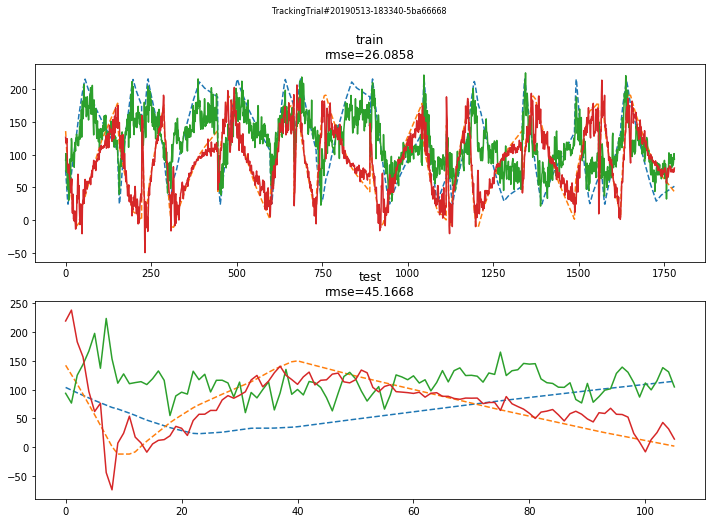

In [180]:
plt.figure(figsize=(12,8))
TrackingTrial().run(dt=0.01, n_data=-1, plt=plt, decay_time=0.01, 
                    test_set='one', n_neurons=2000, 
                    task='location', keep_invalid=False,
                    enhance_training=True,
                    seed=7)